In [1]:
%matplotlib inline

In [87]:
[x/scale for x in np.shape(ski_image)]

[1740.0, 2320.0, 1.5]

/home/laeb/.pyenv/versions/scipy/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/laeb/.pyenv/versions/scipy/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/home/laeb/.pyenv/versions/scipy/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


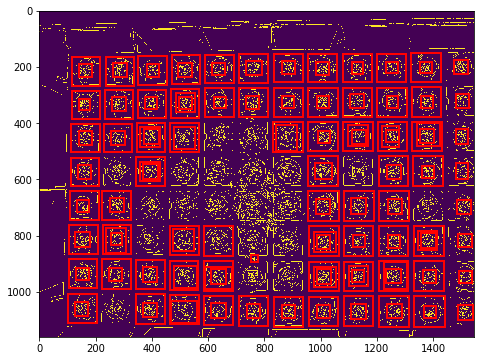

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage import io, feature
from skimage.transform import rescale
from skimage.color import rgb2grey
from pylibdmtx.pylibdmtx import decode
from scipy import ndimage
from multiprocessing import Pool

scale = 2
direction = 'portrait'  # 'landscape'/'portrait'
if direction == 'portrait':
	number_of_y_groups = 12
	number_of_x_groups = 8
else:
	number_of_y_groups = 8
	number_of_x_groups = 12

#ski_image = io.imread("timages/vmsr/scan1.png") # 200 ppm scan, scale =1, direction=portrait  == fail
#ski_image = io.imread("timages/vmsr/scan2.jpg") # 600 ppm scan, scale =2, direction=portrait  == perfect
ski_image = io.imread("timages/op3t/t1.jpg") #perfect
#ski_image = io.imread(ims[4]) #perfect

grey_image = rgb2grey(ski_image)
rescaled = rescale(grey_image, 1/scale, multichannel=False)
#edges = filters.sobel(rescaled)
edges2 = feature.canny(rescaled)
#edges3 = feature.canny(rescaled, sigma=4)
thresh = threshold_otsu(edges2)
bw = closing(edges2 > thresh, square(3))
cleared = clear_border(bw)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(edges2)

for region in regionprops(label(cleared)):
    # take regions with large enough areas
    if region.area >= 500/scale and region.area < 5000/scale:
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

plt.show()

In [92]:
box_ys = np.array([region.bbox[0] for region in regionprops(label(cleared)) if region.area >= 500/scale and region.area <5000/scale])
box_xs = np.array([region.bbox[1] for region in regionprops(label(cleared)) if region.area >= 500/scale and region.area <5000/scale])
y_groups = KMeans(n_clusters=number_of_y_groups).fit_predict(box_ys.reshape(-1,1))
x_groups = KMeans(n_clusters=number_of_x_groups).fit_predict(box_xs.reshape(-1,1))
y_poss = pd.DataFrame({'cat':y_groups, 'data':box_ys}).groupby('cat').median()['data'].to_list()
x_poss = pd.DataFrame({'cat':x_groups, 'data':box_xs}).groupby('cat').median()['data'].to_list()

In [93]:
x_diffs = []
for x in range(len(x_poss)-1):
    x_diffs.append(sorted(x_poss)[x+1]-sorted(x_poss)[x])
y_diffs = []
for x in range(len(y_poss)-1):
    y_diffs.append(sorted(y_poss)[x+1]-sorted(y_poss)[x])
s_size = int(np.median(x_diffs+y_diffs))*scale

In [94]:
#should probably extrapolate positions rather than acception all kmeans

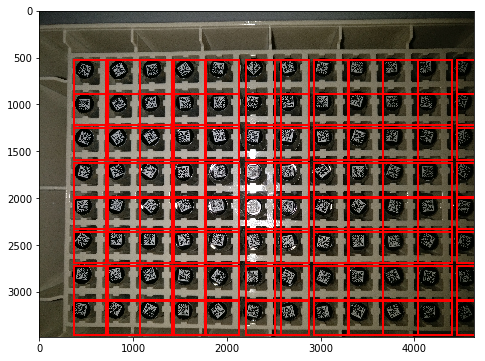

In [95]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(ski_image)

for col, xs in enumerate(sorted(x_poss)):
    for row, ys in enumerate(sorted(y_poss)):
        rect = mpatches.Rectangle((xs*scale, ys*scale), s_size, s_size, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

plt.show()

In [31]:
#for col, xs in enumerate(sorted(x_poss)):
#    for row, ys in enumerate(sorted(y_poss)):
#        well = ski_image[int(ys*scale):int(ys*scale)+s_size,int(xs*scale):int(xs*scale)+s_size]
#        plt.figure()
#        plt.imshow(well)
#    break

In [98]:
"""
    Args:
        image: `numpy.ndarray`, `PIL.Image` or tuple (pixels, width, height)
        timeout (int): milliseconds
        gap_size (int):
        shrink (int):
        shape (int):
        deviation (int):
        threshold (int):
        min_edge (int):
        max_edge (int):
        corrections (int):
        max_count (int): stop after reading this many barcodes. `None` to read
            as many as possible.
            http://libdmtx.wikidot.com/helpful-tips
            """
def decode_thread(pospos):
    col, xs, row, ys = pospos
    well = ski_image[int(ys*scale):int(ys*scale)+s_size,int(xs*scale):int(xs*scale)+s_size]
    res = decode(well, timeout=100, shrink=2, deviation=40, threshold=20, max_count=1)
    if res:
        return {'row': row, 'col': col, 'barcode':res[0].data}
    else:
        found = False
        for i in range(effort):
            res = decode(ndimage.rotate(well, i, reshape=False), timeout=100, max_count=1)
            if res:
                found = True
                return {'row': row, 'col': col, 'barcode':res[0].data}
                break
        if not found:
            return {'row': row, 'col': col, 'failed':well}

effort = 10

pps = []
for col, xs in enumerate(sorted(x_poss)):
    for row, ys in enumerate(sorted(y_poss)):
        pps.append([col, xs, row, ys])

with Pool(4) as p:
    rar = p.map(decode_thread, pps)

In [99]:
count = 0
for r in rar:
    if 'failed' in r:
        #plt.figure()
        #plt.imshow(r['failed'])
        count += 1
print(count)

11


In [76]:
rar[0]

{'row': 0, 'col': 0, 'failed': array([[[33, 48, 15],
         [28, 45, 19],
         [28, 45, 19],
         ...,
         [33, 45, 19],
         [28, 45, 19],
         [28, 40, 24]],
 
        [[33, 45, 19],
         [33, 45, 19],
         [28, 45, 13],
         ...,
         [33, 45, 19],
         [27, 45, 29],
         [28, 40, 31]],
 
        [[39, 45, 13],
         [34, 45, 13],
         [29, 40, 17],
         ...,
         [33, 45, 29],
         [27, 45, 29],
         [33, 40, 32]],
 
        ...,
 
        [[20, 31,  8],
         [20, 31,  8],
         [20, 31,  8],
         ...,
         [30, 35, 23],
         [34, 40, 18],
         [30, 40, 11]],
 
        [[ 6, 23,  8],
         [14, 24,  8],
         [15, 24,  0],
         ...,
         [31, 35, 16],
         [31, 35, 16],
         [30, 40, 11]],
 
        [[ 8, 13,  0],
         [ 8, 13,  0],
         [ 8, 13,  0],
         ...,
         [30, 40, 11],
         [31, 35, 16],
         [31, 35, 16]]], dtype=uint8)}